# **_Santander_ Customer Transaction Prediction**

## Workflow description
1. **Data exploration** - First look at the data to understand which are the most relevant information. General inspection techniques have been used.
2. **Data pre-processing** - Considering the high number of data, a pre-processing with the aim of removing usless information has been carried out.
3. **Train-Test split** - Training dataset is devided into _training_ and _testing_ by following the 80-20 rule.
4. **First model: Decision Tree** - A simple model has been used in order to obtain a baseline. Given the performance of this model, the following ones are tuned in order to improve the baseline performance 
5. **Second model: Gaussian Naive Bayes** - Slightly complex model used to improve the performance obtained so far
6. **Third model: k-Nearest Neighbor** - Slightly complex model used to improve the performance obtained so far
7. **Model comparison** - All models have been compared, using differnet sets of parameters, to see which one has obtained higher performances.
8. **Best model** - Once the best model has been found, a complete training can be carried out.

## Import section

In [1]:
import warnings
warnings.filterwarnings('ignore') # comment this line to suppress warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## 1. Data exploration

There are two sets of data: `train.csv` and `test.csv`.
Since only `train.csv`is provided with the `target` column, the other dataset is not considered

In [2]:
train_url = '/kaggle/input/santander-customer-transaction-prediction/train.csv'
test_url = '/kaggle/input/santander-customer-transaction-prediction/test.csv'
target = 'target'
id_col = 'ID_code' 

random_state = 42
train_size = 0.80
np.random.seed(random_state)
cv = 3

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)
comparison_df = pd.DataFrame(columns=['Scoring','Model name','Parameters', 'accuracy','precision_macro','recall_macro','f1_macro'])

The following information about **data dimensions** refers to `train.csv` and `test.csv`. Since, it is only used the `train.csv` dataset, the real division between **_train_** and **_test_** will be:
- TRAIN: _160.000_ samples
- TEST: _40.000_ samples

In [3]:
print("train.csv: There are {} rows and {} columns".format(train_df.shape[0],train_df.shape[1]))
print("test.csv: There are {} rows and {} columns".format(test_df.shape[0],test_df.shape[1]))

train.csv: There are 200000 rows and 202 columns
test.csv: There are 200000 rows and 201 columns


The `target` column is binary and it indicates if a **transaction** <u>will be made in the future again</u>, regargless the amount.

By looking at the `other features`, it is not possibile to determine which ones are most relevant; the features name is _not self-explanatory_.

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


All the `features` follow a data distribution close to a **Normal Distribution**. This gives us an hint that probabily a good classification model will be the ***Gaussian Navie Bayes*** **classifier**.

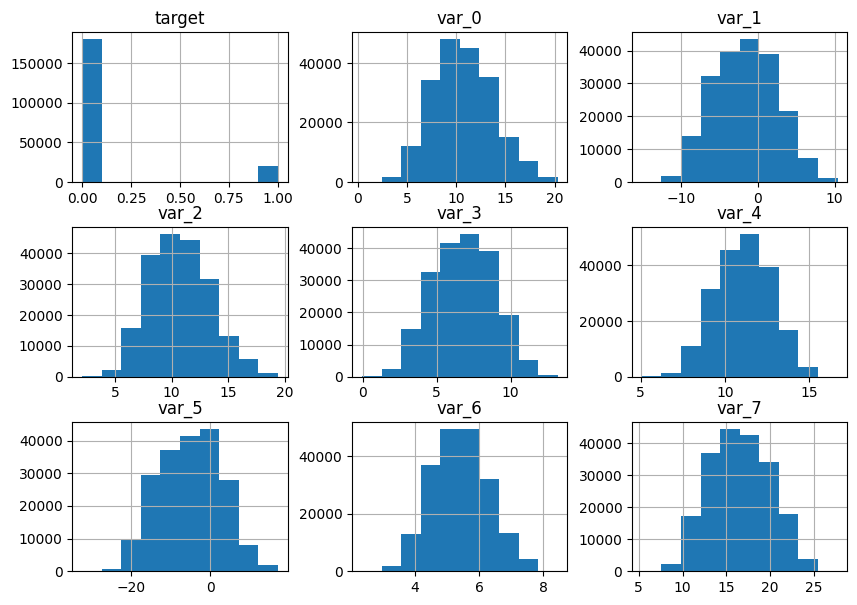

In [6]:
train_df[train_df.columns[0:10]].hist(figsize=(10,7));

Also by looking at the **_correlation matrix_** it is not possible to determine which feature is most relevant in the computataion of the **final prediction**.

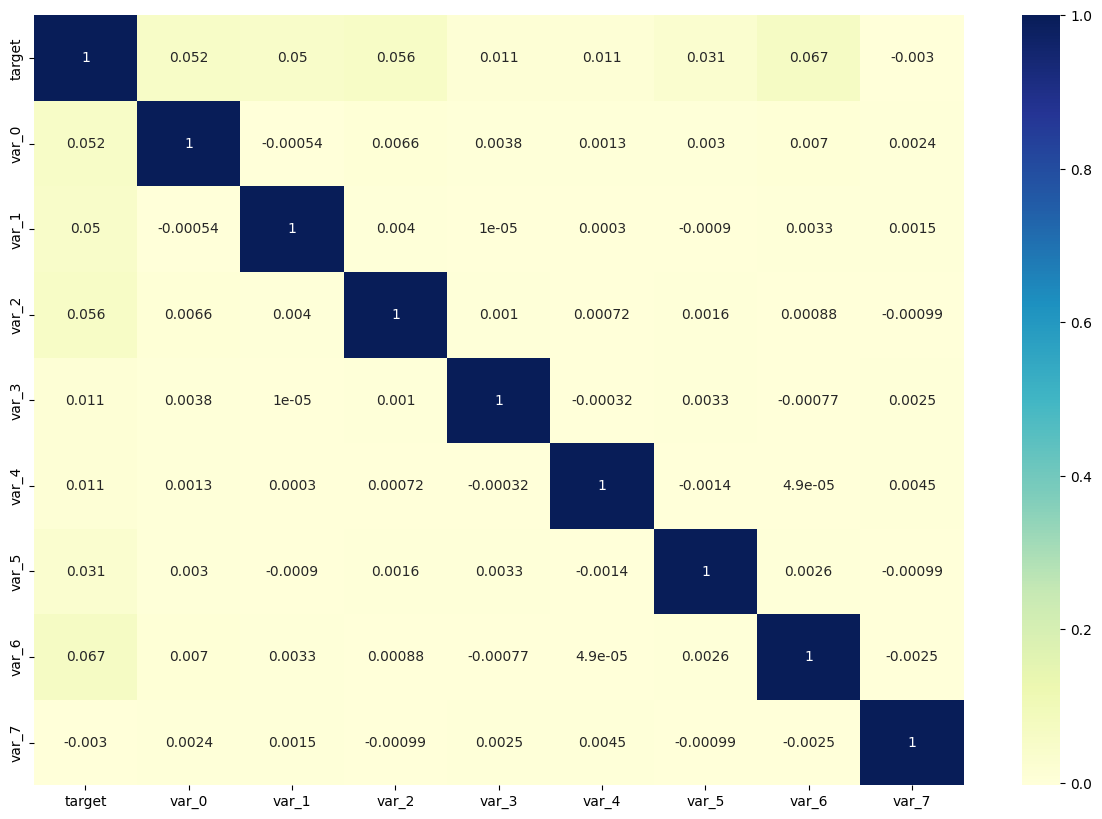

In [7]:
corr = train_df[train_df.columns[0:10]].corr(numeric_only=True)

plt.figure(figsize=(15,10)) # set X and Y size
sns.heatmap(corr, cmap="YlGnBu", annot=True);

## 2. Data pre-processing

Two pre-processing step have been done:
- The **index column**, called '`ID_code`', has been dropped since it is now useless for the training of the model.
- All _**NaN**_ value have been dropped (if any).

In [8]:
train_df.drop(columns=[id_col], inplace=True)
train_df.isna().sum().unique() # no NaN value have been found

array([0])

## 3. Train-Test split

The data available are divided in the following way:
- 80% for **training**
- 20% for **testing**

In order to test all the different _**hyper-parameters configuration**_, during the first part of the **training**, only a subset of the complete dataset has been used. Once the **best _model_** and the **best _parameters_** have been found, a complete training is carried out.

In [9]:
n_samples = 50_000

X = train_df.drop(target, axis=1)
y = train_df[target]

X_small = X[:n_samples]
y_small = y[:n_samples]

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, random_state = random_state, train_size = train_size)

For all the following **_models_**, the evaluation considers different metrics:
- `accuracy`,`precision`,`recall`,`f1-score`

A **macro average** is used for computing the _overall performance_. By doing this, we are calculating first the metrics for each label, and then their unweighted mean. This does not take **_label imbalance_** into account.

## 4. First model: **_DecisionTreeClassifier_**

A ***Decision Tree*** **classifier** creates an upside-down tree to make predictions, starting at the top with a question about an important feature in the data, then branches out based on the answers. As we follow these branches down, each stop asks another question, narrowing down the possibilities. This _question-and-answer_ game continues until we reach the bottom — a **leaf node** — where we get our **final prediction** or **classification**.

Definition by [medium.com](https://medium.com/data-science/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e)

In [10]:
model = DecisionTreeClassifier(criterion = 'entropy')

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      9047
           1       0.17      0.19      0.18       953

    accuracy                           0.84     10000
   macro avg       0.54      0.55      0.54     10000
weighted avg       0.84      0.84      0.84     10000



In [12]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print("The accuracy on test set is {0:.2f}%".format(accuracy * 100))
print("The precision_macro on test set is {0:.2f}%".format(precision * 100))
print("The recall_macro on test set is {0:.2f}%".format(recall * 100))
print("The f1_macro on test set is {0:.2f}%".format(f1 * 100))


The accuracy on test set is 83.61%
The precision_macro on test set is 54.29%
The recall_macro on test set is 54.66%
The f1_macro on test set is 54.45%


## 5. Second model: **_Gaussian Naive Bayes_**

***Gaussian Naive Bayes*** (**GNB**) is a machine learning classification technique based on a **probabilistic approach** that assumes each *feature* follows a **Gaussian (normal) distribution**. 
It assumes each parameter has an <u>independent capacity of predicting the output variable</u>.

The combination of the prediction for all parameters is the **final prediction** that returns a probability of the dependent variable to be classified in each group. The **final classification** is assigned to the group with the higher probability.

Definition by [builtin.com](https://builtin.com/artificial-intelligence/gaussian-naive-bayes)

In [13]:
model = GaussianNB()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      9047
           1       0.70      0.37      0.48       953

    accuracy                           0.92     10000
   macro avg       0.82      0.68      0.72     10000
weighted avg       0.91      0.92      0.91     10000



In [15]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print("The accuracy on test set is {0:.2f}%".format(accuracy * 100))
print("The precision_macro on test set is {0:.2f}%".format(precision * 100))
print("The recall_macro on test set is {0:.2f}%".format(recall * 100))
print("The f1_macro on test set is {0:.2f}%".format(f1 * 100))

The accuracy on test set is 92.46%
The precision_macro on test set is 81.65%
The recall_macro on test set is 67.67%
The f1_macro on test set is 72.14%


## 6. Third model: **_k-Nearest Neighbor_**


A ***K-Nearest Neighbor*** **classifier** is a machine learning model that makes predictions based on the majority class of the K nearest data points in the feature space. The ***KNN*** algorithm assumes that <u>similar things exist in close proximity</u>, making it intuitive and easy to understand.

Definition by [medium.com](https://towardsdatascience.com/k-nearest-neighbor-classifier-explained-a-visual-guide-with-code-examples-for-beginners-a3d85cad00e1/)

In [16]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9047
           1       0.30      0.00      0.01       953

    accuracy                           0.90     10000
   macro avg       0.60      0.50      0.48     10000
weighted avg       0.85      0.90      0.86     10000



In [18]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print("The accuracy on test set is {0:.2f}%".format(accuracy * 100))
print("The precision_macro on test set is {0:.2f}%".format(precision * 100))
print("The recall_macro on test set is {0:.2f}%".format(recall * 100))
print("The f1_macro on test set is {0:.2f}%".format(f1 * 100))

The accuracy on test set is 90.43%
The precision_macro on test set is 60.25%
The recall_macro on test set is 50.12%
The f1_macro on test set is 47.80%


## 7. Model comparison

Thanks to the previous training with each one of the **models**, it is possibile to have a general idea to which one could work best for this kind of task, but a more detailed exploration is needed.

For each one of the previous **models**, a **_Grid Seach_** has been carried out, and the comparision has been done using **four metrics**: 
- **_Accuracy, Precision, Recall, F1-Score_**

In [19]:
model_lbls = ['decision_tree', 'gaussian_nb','knn']

models = {
    'decision_tree': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'gaussian_nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
           },
}

scorings = ['accuracy','precision_macro','recall_macro','f1_macro']
clfs = []

In [20]:
for scoring in scorings:
    for m in model_lbls:
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv = cv, scoring = scoring)
        clf.fit(X_train, y_train)   
        clfs.append(clf)
        
        y_true, y_pred = y_test, clf.predict(X_test)

        cr = classification_report(y_true,y_pred, output_dict=True, zero_division=1)
        
        comparison_df.loc[len(comparison_df)] = [scoring, models[m]['name'], clf.best_params_,
                                     cr['accuracy'],
                                     cr['macro avg']['precision'],
                                     cr['macro avg']['recall'],
                                     cr['macro avg']['f1-score']]

In [21]:
comparison_df.head()

,Scoring,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
0,accuracy,Decision Tree,"{'class_weight': None, 'max_depth': 1}",0.9047,0.952350,0.500000,0.474983
1,accuracy,Gaussian Naive Bayes,{'var_smoothing': 1e-08},0.9244,0.815485,0.676114,0.720708
2,accuracy,K Nearest Neighbor,{'n_neighbors': 6},0.9047,0.702390,0.500469,0.476027
3,precision_macro,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.9038,0.584089,0.501850,0.479865
4,precision_macro,Gaussian Naive Bayes,{'var_smoothing': 0.001},0.9189,0.847935,0.602196,0.644121


The **best model** is considered by taking into account all the performance achieved in all the different **scorings**.

Points have been assigned to each **model**:
- **_3 pt_** for the **1st model**
- **_2 pt_** for the **2nd model**
- **_1 pt_** for the **3rd model**

In [22]:
best_models = {'Decision Tree': 0, 'Gaussian Naive Bayes': 0, 'K Nearest Neighbor': 0}

for score in scorings:
    scoring_filter = score
    
    best_models[comparison_df[comparison_df.Scoring==scoring_filter].sort_values(by=scoring_filter,ascending=False).iloc[0]['Model name']] += 3
    best_models[comparison_df[comparison_df.Scoring==scoring_filter].sort_values(by=scoring_filter,ascending=False).iloc[1]['Model name']] += 2
    best_models[comparison_df[comparison_df.Scoring==scoring_filter].sort_values(by=scoring_filter,ascending=False).iloc[2]['Model name']] += 1
    
    print(f'\nThe best models, considering <{score}>, are the following:')
    
    if score == 'f1_macro':
        for model in model_lbls:
            if models[model]['name'] == comparison_df[comparison_df.Scoring==scoring_filter].sort_values(by=scoring_filter,ascending=False)\
                                                                                            .head(1)['Model name'].iloc[0]:
                best_model = models[model]['estimator']
                best_params = comparison_df[comparison_df.Scoring==scoring_filter].sort_values(by=scoring_filter,ascending=False).head(1)['Parameters'].iloc[0]
                best_model.set_params(**best_params)
        
    display(comparison_df[comparison_df.Scoring==scoring_filter]\
                .sort_values(by=scoring_filter,ascending=False)\
                .drop('Scoring',axis=1)\
                .head(3)
    )

print(f'\nThe best model is: {best_model}')
print(f'\nThe best parameters for this model are: {best_params}')


The best models, considering <accuracy>, are the following:


,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
1,Gaussian Naive Bayes,{'var_smoothing': 1e-08},0.9244,0.815485,0.676114,0.720708
0,Decision Tree,"{'class_weight': None, 'max_depth': 1}",0.9047,0.952350,0.500000,0.474983
2,K Nearest Neighbor,{'n_neighbors': 6},0.9047,0.702390,0.500469,0.476027



The best models, considering <precision_macro>, are the following:


,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
4,Gaussian Naive Bayes,{'var_smoothing': 0.001},0.9189,0.847935,0.602196,0.644121
5,K Nearest Neighbor,{'n_neighbors': 5},0.9043,0.602452,0.501187,0.477980
3,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.9038,0.584089,0.501850,0.479865



The best models, considering <recall_macro>, are the following:


,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
7,Gaussian Naive Bayes,{'var_smoothing': 1e-09},0.9246,0.816524,0.676694,0.721446
6,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 4}",0.6377,0.529828,0.580092,0.488019
8,K Nearest Neighbor,{'n_neighbors': 1},0.8749,0.519650,0.508878,0.506180



The best models, considering <f1_macro>, are the following:


,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
10,Gaussian Naive Bayes,{'var_smoothing': 1e-09},0.9246,0.816524,0.676694,0.721446
9,Decision Tree,"{'class_weight': None, 'max_depth': 19}",0.8723,0.562244,0.538421,0.544558
11,K Nearest Neighbor,{'n_neighbors': 1},0.8749,0.519650,0.508878,0.506180



The best model is: GaussianNB()

The best parameters for this model are: {'var_smoothing': 1e-09}


## 8. Best model

Lets see which one is the **best model**:

In [23]:
print(f'These are the final results: \n\t{best_models}')

These are the final results: 
	{'Decision Tree': 7, 'Gaussian Naive Bayes': 12, 'K Nearest Neighbor': 5}


After all the comparisons, the **best model** has been found: the metric used to pick the best one is **_F1-Score_**.

To speed up the computations, all the trainings before have been done with a smaller number of _samples_ with respect to the all _available samples_ for **training**.
Now it is possible to operate a full **_training_** on the **best model**.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = train_size)

In [25]:
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     35903
           1       0.72      0.37      0.49      4097

    accuracy                           0.92     40000
   macro avg       0.83      0.68      0.72     40000
weighted avg       0.91      0.92      0.91     40000



## Conclusions

Three models have been chosen to be compared in order to find the one that better fits this kind of task. Even during the first steps of data analysis, while looking at the **data distributions** and at the **correlation matrix**, it was thought that `Gaussian Naive Bayes` might be a valid model, since it assumes that data are <u>**independent** and follow a **normal distribution**</u>.
Indeed, after all the tests and comparisons between the models, `Gaussian Naive Bayes` stood out among the other two.

Looking at the results from the final run, where all the data have been used, we can conclude that the final model is able to classify almost all the _negative samples_, whereas the _positive samples_ are classified correctly approximately 50% of the time; this is a great result if compared with the outcome of the other two models.